In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import folium
import os
from datetime import datetime, timedelta
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
print(os.getcwd())

C:\Users\gijsd\Google Drive\Uni\AT year 3\Bachelor Assignment\thesis_code\experiment_data\dimension_axis_test


In [10]:
fileName = 'Align_Axis_Test_16-05-2023 15-52-13.335'
print(fileName)
df_phone = pd.read_csv(fileName + "_phone.csv", header=None)
df_gps = pd.read_csv(fileName + "_gps.csv", header=None)
df_thingy = pd.read_csv(fileName + "_thingy.csv", header=None)
df_phone.columns = ['timeStamp',
                    'mAcc_0','mAcc_1','mAcc_2', # Phone acc is in m/s^2 according to android studio
                    'mAcc_cal_0','mAcc_cal_1','mAcc_cal_2', #calibrated phone accelerometer
                    'mGyr_0','mGyr_1','mGyr_2']
df_gps.columns = [
    'timeStamp',
    'currentSpeed','distance',
    'mLocationLat','mLocationLong',
]
df_thingy.columns = [
    'timeStamp',
    'xa','ya','za',
    'xa_cal','ya_cal','za_cal', # Calibrated Thingy:52 accelerometer
    'xg','yg','zg'
]

def processDataFrame(df):
    df['timeStamp'] = df['timeStamp'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
    start_time = df['timeStamp'].iloc[0]
    df['Time (s)'] = (df['timeStamp'] - start_time).dt.total_seconds()
    total_time = df['Time (s)'].iloc[-1]
    fs = len(df)/total_time # Sampling frequency of Thingy, should be 200 Hz

    #P1 configuration, align coordinates of phone to thingy, dimension sync
    if "mAcc_0" in df.columns: #Phone df
        #Acc: Z = -Z, X = -Y and Y = -X
        df['mAcc_2'], df['mAcc_cal_2'], df['mAcc_0'],  df['mAcc_cal_0'], df['mAcc_1'], df['mAcc_cal_1'] = df['mAcc_2'], df['mAcc_cal_2'], -df['mAcc_1'],  -df['mAcc_cal_1'], df['mAcc_0'], -df['mAcc_cal_0']

        #Gyr: Z = -Z, Y = X, X = Y
        df['mGyr_0'], df['mGyr_1'], df['mGyr_2'] = df['mGyr_1'], df['mGyr_0'], -df['mGyr_2']

    #TODO: Fix time sync by using only timestamp filtering from phone for example and apply to other dataframe
    #TODO: first fix time delay thingy

    t_interval_start = 0
    t_interval_end = 200
    idx1 = (df['Time (s)'] - t_interval_start).abs().idxmin()
    idx2 = (df['Time (s)'] - t_interval_end).abs().idxmin()
    dt1 = df.loc[idx1, 'timeStamp']
    dt2 = df.loc[idx2, 'timeStamp']
    df = df.loc[(df['timeStamp'] >= dt1) & (df['timeStamp'] <= dt2)]

    return fs, df

fs_phone, df_phone = processDataFrame(df_phone)
fs_gps, df_gps = processDataFrame(df_gps)
fs_t, df_thingy = processDataFrame(df_thingy)

print(f'fs_phone = {fs_phone} Hz\nfs_gps = {fs_gps} Hz\nfs_thingy = {fs_t} Hz')

Align_Axis_Test_16-05-2023 15-52-13.335
fs_phone = 514.6824822797628 Hz
fs_gps = 1.2196981247141332 Hz
fs_thingy = 196.55022467024207 Hz


In [11]:
t_acc = df_thingy.dropna(subset = ['xa', 'ya', 'za', 'xa_cal', 'ya_cal', 'za_cal'])[['Time (s)', 'xa', 'ya', 'za', 'xa_cal', 'ya_cal', 'za_cal']]
t_gyr = df_thingy.dropna(subset = ['xg', 'yg', 'zg'])[['Time (s)', 'xg', 'yg', 'zg']]
p_acc = df_phone.dropna(subset=['mAcc_0', 'mAcc_1', 'mAcc_2', 'mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2'])[['Time (s)', 'mAcc_0', 'mAcc_1', 'mAcc_2', 'mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2']]
p_gyr = df_phone.dropna(subset=['mGyr_0', 'mGyr_1', 'mGyr_2'])[['Time (s)', 'mGyr_0', 'mGyr_1', 'mGyr_2']]

for col in ['mGyr_0','mGyr_1','mGyr_2']:
    p_gyr[col] = p_gyr[col] * 180 / math.pi # Change phone angular velocity to deg/s

gravity_fac = 9.81
t_acc.iloc[:, 1:] = t_acc.iloc[:, 1:].multiply(gravity_fac) # Change thingy acceleration to m/s^2

# Sampling frequency of phone sensors
fs_p_acc = len(p_acc) / (p_acc['Time (s)'].iloc[-1] - p_acc['Time (s)'].iloc[0])
fs_p_gyr = len(p_gyr) / (p_gyr['Time (s)'].iloc[-1] - p_gyr['Time (s)'].iloc[0])
print(f'Sample frequency of phone_acc = {fs_p_acc} Hz\nSample frequency of phone_gyr = {fs_p_gyr} Hz')

# ___Time axis___
t_acc_time = np.arange(len(t_acc)) / fs_t
#t_acc_time = t_acc['Time (s)']
p_acc_time = np.arange(len(p_acc)) / fs_p_acc
#p_acc_time = p_acc['Time (s)']
t_gyr_time = np.arange(len(t_gyr)) / fs_t
#t_gyr_time = df_thingy['Time (s)']
p_gyr_time = np.arange(len(p_gyr)) / fs_p_gyr
#p_gyr_time = p_gyr['Time (s)']

Sample frequency of phone_acc = 207.32060185185185 Hz
Sample frequency of phone_gyr = 207.32060185185185 Hz


t_m for this maneuver: 3.2663407079646016


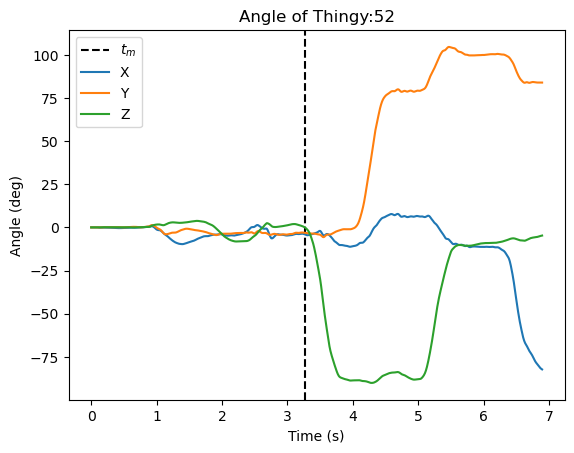

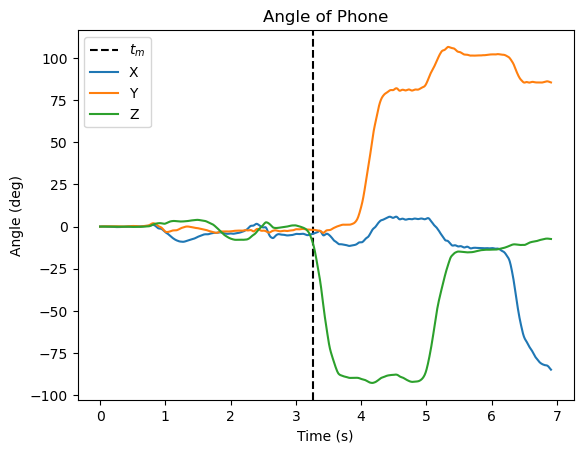

In [12]:
# Compute the cumulative sum of the gyroscope data for each dimension to get the angle
t_angle = pd.DataFrame()
t_angle['x'] = np.cumsum(t_gyr['xg'])*(1/fs_t)
t_angle['y'] = np.cumsum(t_gyr['yg'])*(1/fs_t)
t_angle['z'] = np.cumsum(t_gyr['zg'])*(1/fs_t)
t_angle['Time (s)'] = t_gyr_time

p_angle = pd.DataFrame()
p_angle['x'] = np.cumsum(p_gyr['mGyr_0'])*(1/fs_p_gyr)
p_angle['y'] = np.cumsum(p_gyr['mGyr_1'])*(1/fs_p_gyr)
p_angle['z'] = np.cumsum(p_gyr['mGyr_2'])*(1/fs_p_gyr)
p_angle['Time (s)'] = p_gyr_time

# Find the index of the last point that crosses the time-axis
crossings = (t_angle['z'].shift(1) >= 0) != (t_angle['z'] >= 0)
last_crossing_time = t_angle.loc[crossings[::-1].idxmax(), 'Time (s)']
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
print(f't_m for this maneuver: {last_crossing_time}')

# Plot the Thingy:52 angles
plt.plot(t_angle['Time (s)'], t_angle['x'], label='X')# Tilt of bike
plt.plot(t_angle['Time (s)'], t_angle['y'], label='Y')# Driving up and downhill
plt.plot(t_angle['Time (s)'], t_angle['z'], label='Z')# Direction of bike
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Thingy:52'), plt.legend(loc='best')
plt.show()

# Plot the phone angles
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
plt.plot(p_angle['Time (s)'], p_angle['x'], label='X')
plt.plot(p_angle['Time (s)'], p_angle['y'], label='Y')
plt.plot(p_angle['Time (s)'], p_angle['z'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Phone'), plt.legend(loc='best')
plt.show()

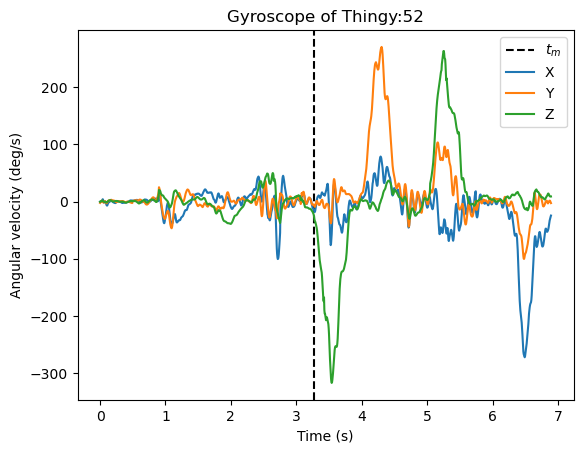

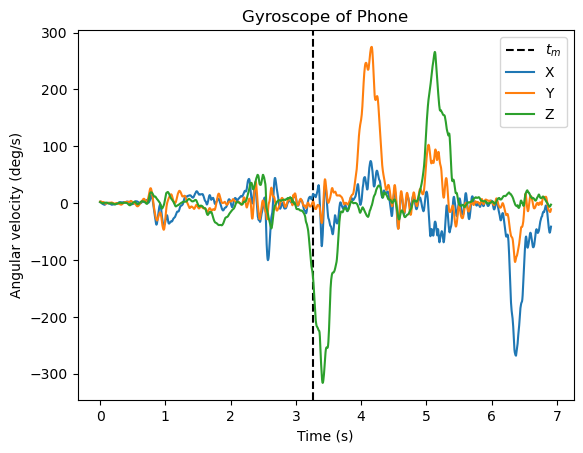

In [13]:
#Thingy gyroscope
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
plt.plot(t_gyr_time,df_thingy['xg'], label='X')
plt.plot(t_gyr_time,df_thingy['yg'], label='Y')
plt.plot(t_gyr_time,df_thingy['zg'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Thingy:52'), plt.legend(loc='best')
plt.show()

#Phone gyroscope
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
plt.plot(p_gyr_time, p_gyr['mGyr_0'], label='X')
plt.plot(p_gyr_time, p_gyr['mGyr_1'], label='Y')
plt.plot(p_gyr_time, p_gyr['mGyr_2'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Phone'),plt.legend(loc='best')
plt.show()

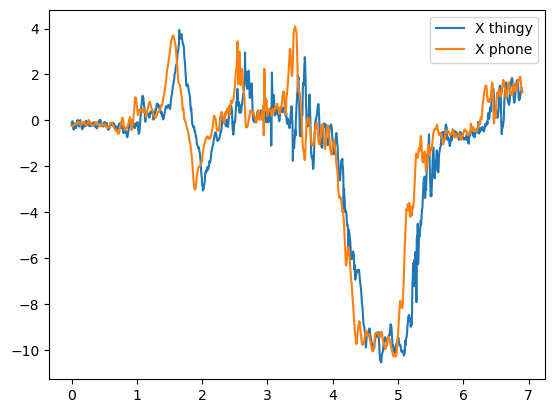

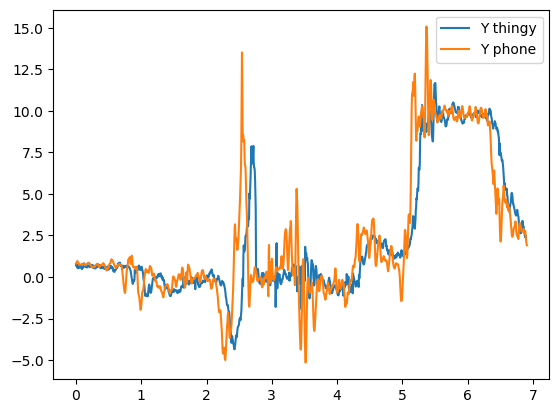

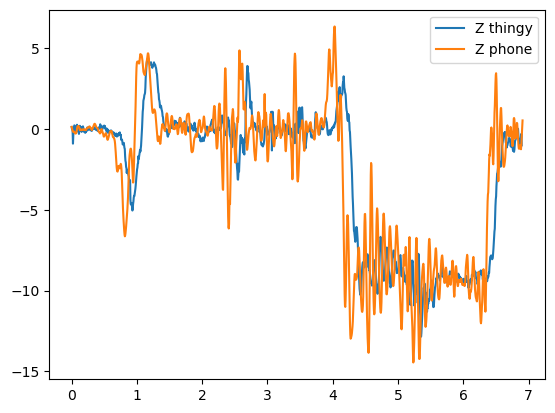

(<matplotlib.legend.Legend at 0x16d0cf23f10>, None)

In [14]:
plt.plot(t_acc_time, t_acc['xa_cal'], label='X thingy')
plt.plot(p_acc_time, p_acc['mAcc_cal_0'], label='X phone')
plt.legend(loc='best'), plt.show()
plt.plot(t_acc_time, t_acc['ya_cal'], label='Y thingy')
plt.plot(p_acc_time, p_acc['mAcc_cal_1'], label='Y phone')
plt.legend(loc='best'), plt.show()
plt.plot(t_acc_time, t_acc['za_cal'], label='Z thingy')
plt.plot(p_acc_time, p_acc['mAcc_cal_2'], label='Z phone')
plt.legend(loc='best'), plt.show()